In [1]:
%run 0_parameters.ipynb


WELCOME



In [2]:
if not os.path.exists('figures/BCP'):
    os.makedirs('figures/BCP')


# the switching binomial generative model


In [4]:
msfigpath = '../PasturelMontagniniPerrinet2019/figures'
observer = 'AM'
mode = 'pari'
from aSPEM import Analysis
import bayesianchangepoint as bcp
e = Analysis(observer=observer, mode=mode)

/!\ Le fichier Delete n'existe pas pour fct_velocity_2_step_False_whitening !


# the online BCP model: figures for the model

In [5]:
N_trials = 10 # 100
seed = 2020
np.random.seed(seed)
p0, r0 =  0.5, 1.0
trials = np.arange(N_trials)
p = np.random.rand(N_trials, 3)
p[:, 2] = 0
p[N_trials//2, 2] = 1

p[:N_trials//2, 1] = .5 #.15
p[N_trials//2:, 1] = .9 #.85

for trial in trials:
    p[trial, 0] =  p[trial, 1] > np.random.rand() # Bernouilli trial

tau = N_trials//2
h = 1/tau
p_bar, r_bar, beliefs = bcp.inference(p[:, 0], h=h, p0=p0, r0=r0)
p_hat, r_hat = bcp.readout(p_bar, r_bar, beliefs, mode='max', p0=p0)
p_hat, r_hat_mean = bcp.readout(p_bar, r_bar, beliefs, mode='mean', p0=p0)
p_hat, r_hat_leaky = bcp.readout(p_bar, r_bar, beliefs, mode='leaky', p0=p0)

print(r_hat)

[1. 2. 3. 4. 5. 6. 7. 8. 9. 1.]


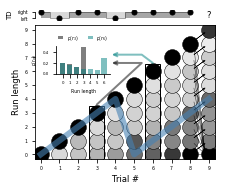

In [22]:
import matplotlib.gridspec as gridspec

def arrow_1(ax, x, y, alpha):
    plt.arrow(x+r_cir, y+r_cir, 1-(r_cir*2), 1-(r_cir*2),
              head_width=s_arrow, head_length=s_arrow, fc=c_f1, ec=c_f1, alpha=alpha,
              length_includes_head=True, lw=0.5)

def arrow_2(ax, x, y, alpha):
    if y==0 : y1=0 ; y2=0 ; x1=x+r_cir+r_cir*0.3 ; x2=1-(r_cir*2)-r_cir*0.3
    else :    y1=y-r_cir ; y2=-y+r_cir ; x1=x+r_cir ; x2=1-(r_cir*2)
    
    plt.arrow(x1, y1, x2, y2,
              head_width=s_arrow, head_length=s_arrow, fc=c_f2, ec=c_f2, alpha=0.4,
              length_includes_head=True,  lw=0.5)

        
r_cir, lw_cir, s_arrow = 0.2, 3, 0.1 # 0.2, 3, 0.09
alpha = .2

c_f1, c_f2, c_cir = 'k', 'k', 'k' #'k', 'r', 'k'
num = N_trials


fig_width = 15/3
t_titre = 35/3
t_label = 25/3
fig_width= 15/3
#N_scan = 10 # DEBUG
#------------------------------------------------
fig, axs = plt.subplots(2, 1, figsize=(fig_width, ((2+0.5)*fig_width/3)/(1.6180)))

gs1 = gridspec.GridSpec(1, 1)
gs1.update(left=0, bottom=0.85, right=0.5, top=1.-0.1, hspace=0.05)
axs[0] = plt.subplot(gs1[0])

for card in ['bottom', 'top', 'right']: axs[0].spines[card].set_visible(False)
axs[0].spines['left'].set_bounds(0, 1)
axs[0].set_yticks([0,1])
axs[0].set_yticklabels(['left','right'],fontsize=t_label/1.8)

ec = 0.2
color=[['k', 'k'], [color_true_p, color_true_p], ['k','none']]
Alpha = [[.35,.15],[.0,.0],[1,0]]

x = np.arange(N_trials-1)
y = p[:-1, 0]


axs[0].plot(x, y, 'k.', ms=10)
axs[0].step(x, y, lw=1, c=color[0][0], alpha=Alpha[0][0], where='mid')
axs[0].fill_between(x, np.zeros_like(y), y, lw=.5, alpha=Alpha[0][0], facecolor=color[0][0], step='mid')
axs[0].fill_between(x, np.ones_like(y), y, lw=.5, alpha=Alpha[0][1], facecolor=color[0][1], step='mid')
axs[0].text(N_trials-1, 0.5, '?', fontsize=t_label, va='center', ha='center')

axs[0].set_ylabel('TD', fontsize=t_label/1.2)
axs[0].set_xticks(())

gs2 = gridspec.GridSpec(1, 1)
gs2.update(left=0, bottom=0+0.1, right=0.5, top=0.85-0.03, hspace=0.05)
axs[1] = plt.subplot(gs2[0])
ax=axs[1]

for a in axs :
    a.set_xlim(-0.1,N_trials+0.1)
    a.tick_params(labelsize=t_label/1.8)

for x in trials:
    if x < num: runlengths = range(x+1)
    else:       runlengths = range(num)
    
    b = beliefs[:, x].tolist()
    c = [plt.cm.Greys(i) for i in b/np.max(b)]
    
    for r in runlengths:
        ax.scatter(x, r, s=250, c=[c[r]], alpha=1, edgecolors='k', lw=0.5)
        if x == N_trials-2 : arrow_1(ax, x, r, alpha=1) ; arrow_2(ax, x, r, alpha=1)


#ax.plot(r_hat-1, lw=6, alpha=0.6, c='k')
#ax.plot(r_hat_mean-1, lw=6, alpha=0.6, c=color_bcp_mean)
#ax.plot(r_hat_leaky-1, lw=6, alpha=0.6, c=color_bcp_fix)

r_true = np.arange(N_trials)
r_true[N_trials//2:] = np.arange(N_trials//2)

ax.plot(r_true, lw=6, alpha=0.6, c=color_true_p)

ax.tick_params(bottom=True, top=False, right=False, left=True)
ax.set_ylabel('Run length', fontsize=t_label)
ax.set_xlabel('Trial #', fontsize=t_label)
ax.set_xticks(trials)
ax.set_yticks(np.arange(0, N_trials))
ax.set_xticklabels(np.arange(0, N_trials))
ax.set_yticklabels(np.arange(0, N_trials))



a1 = fig.add_axes([0.06, 0.56, 0.15,0.15])
connectionstyle = "arc,angleA=-90,angleB=0,armA=0,armB=30,rad=0"

NUMT = [3,6]

for num_t, c in zip(NUMT, ['k', 'teal']) :
    #a1.plot(beliefs[:, num_t], c=c, lw=2, label='$p(r_%s)$'%num_t)
    a1.bar(np.arange(N_trials), beliefs[:, num_t], color=c, alpha=0.5, label='$p(r_%s)$'%num_t)
    ax.annotate("", xy=(3.8, 6+(num_t/5)), xytext=(num_t, num_t+0.6),
                arrowprops=dict(arrowstyle="->", color=c, alpha=0.5, lw=2,
                                shrinkA=0, shrinkB=0, patchA=None, patchB=None,
                                connectionstyle=connectionstyle), fontsize=t_label)
    ax.bar(num_t, num_t+2*0.5,  bottom=-0.5, color=(0,0,0,0), edgecolor='k')

    
a1.legend(fontsize=t_label/1.8, ncol=2, bbox_to_anchor=(0, 1.05, 1, 0),
          loc=3, mode="expand", borderaxespad=0., handlelength=1, frameon=False)
a1.set_xticks(np.arange(N_trials))
a1.set_ylabel('$p(r_x)$', fontsize=t_label/1.8)
a1.set_xlim((0-0.9, max(NUMT)+0.9))
a1.set_xlabel('Run length', fontsize=t_label/1.8)
a1.tick_params(labelsize=t_label/2.1)
for card in ['top', 'right']: a1.spines[card].set_visible(False)

ax.axis([-0.32, (num+0.32)-1, -0.32, (num+0.32)-1])
axs[0].axis([-0.32, (num+0.32)-1, -ec, 1+ec])
#for ext in exts: plt.savefig('figures/BCP/bcp_model_layer_%s%s' % (layer, ext))

plt.show()

In [ ]:
plt.tick_params()

In [10]:
figname = '3_BCP_model'
for ext in exts: fig.savefig('{msfigpath}/{figname}'.format(msfigpath=msfigpath, figname=figname) + ext, dpi=dpi, bbox_inches='tight', pad_inches=0)

# chosen readout with a comparison with 'fixed'

In [3]:
t_titre = 35
t_label = 25
fig_width= 15
N_scan = 100
#N_scan = 10 # DEBUG

In [9]:
figname = '3_BCP_readouts'
num_block = 0

/usr/local/lib/python3.5/dist-packages/matplotlib/gridspec.py:335: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


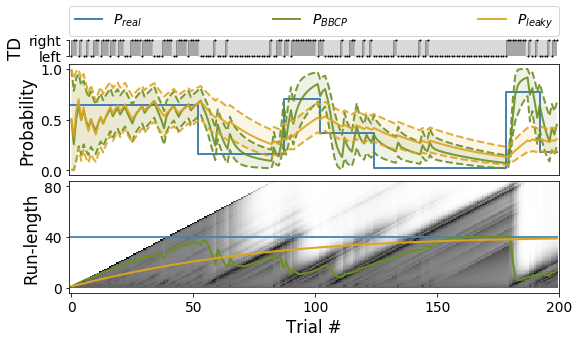

In [10]:
color = [['k', 'k'], [color_true_p, color_true_p], ['k','w']]
alpha = [[.35,.15],[.0,.0],[1,0]]
fig, ax1, ax2 = e.plot_bcp(mode=['mean'], mode_compare='leaky', block=num_block, trial=50, max_run_length=85, 
                           c_mode=color_bcp_mean, c_compare=color_bcp_fix, color=color,
                           N_scan=0, show_title=None, show_trial=False, fig_width=8, t_label=25,
                           leg_up=True, TD=True, alpha=alpha)
#for card in ['bottom', 'top']: 
#    ax1.spines[card].set_visible(False)
#    ax2.spines[card].set_visible(False)
##ax1.legend(loc='best')
#ax2.set_ylim(0, 80)
for ext in exts: fig.savefig('{msfigpath}/{figname}'.format(msfigpath=msfigpath, figname=figname) + ext, dpi=dpi, bbox_inches='tight', pad_inches=0)